# Ebola

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [9]:
df = pd.read_csv("/kaggle/input/ebola-outbreak-20142016-complete-dataset/ebola_2014_2016_clean.csv", parse_dates=["Date"])
df = df.rename(columns={"Cumulative no. of confirmed, probable and suspected cases": "Cases",
           "Cumulative no. of confirmed, probable and suspected deaths": "Deaths"})
df.head()

,Country,Date,Cases,Deaths
0,Guinea,2014-08-29,648.0,430.0
1,Nigeria,2014-08-29,19.0,7.0
2,Sierra Leone,2014-08-29,1026.0,422.0
3,Liberia,2014-08-29,1378.0,694.0
4,Sierra Leone,2014-09-05,1261.0,491.0


In [11]:
gu = df[df["Country"]=="Guinea"]\
    .drop(columns=["Country"])\
    .fillna(0.0)\
    .set_index("Date")\
    .resample("d").interpolate("linear")
gu.head()

,Cases,Deaths
Date,,
2014-08-29,648.000000,430.000000
2014-08-30,671.428571,442.428571
2014-08-31,694.857143,454.857143
2014-09-01,718.285714,467.285714
2014-09-02,741.714286,479.714286


<Axes: xlabel='Date'>

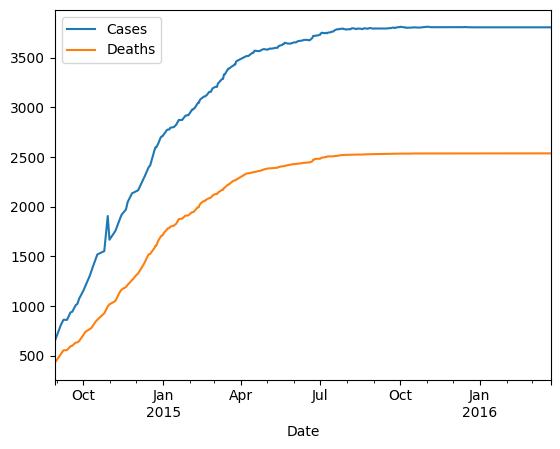

In [12]:
gu.plot()

In [14]:
gu.index.max() - gu.index.min(), len(gu)

(Timedelta('572 days 00:00:00'), 573)

In [15]:
gu_ca = gu["Cases"].to_numpy()
gu_de = gu["Deaths"].to_numpy()

## Fit

/tmp/ipykernel_1243/3961835099.py:64: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(fit, x0, method='nelder-mead',


N 8.3e+06	beta 3.5e-01	alpha 3.5e-04	gamma 1.9e-03	mu 6.7e-01	E0 1.6e+06	R0 9.4e-01


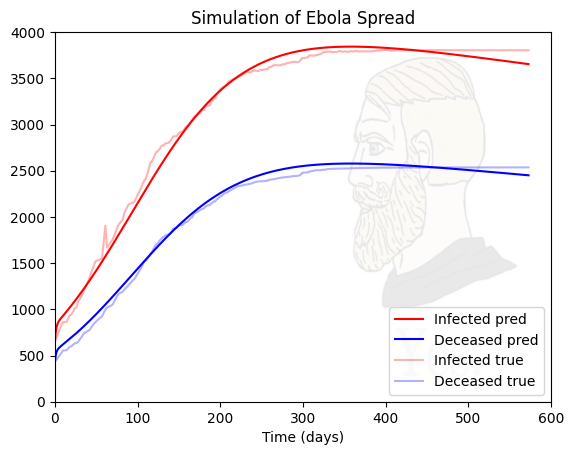

100.30816212517593

In [107]:
def SEIR(y, t, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    dS = - beta * S * I / N
    dE = beta * S * I / N - alpha * E
    dI = alpha * E - gamma * I - mu * I
    dR = gamma * I #- mu * R
    dD = mu * dI
    return [dS, dE, dI, dR, dD]

def fit(x, plot=False):
#     N = 20000     # total population
    I0 = 648          # initial number of infected individuals
    D0 = 430           # initial number of deceased individuals

    N = x[0]           # population
    beta = x[1]       # transmission rate (per day)
    alpha = x[2]      # incubation rate (per day)
    gamma = x[3]    # recovery rate (per day)
    mu = x[4]        # death rate (per day)
    E0 = x[5]         # initial number of exposed individuals
    R0 = x[6]           # initial number of recovered individuals

    S0 = N - E0 - I0 - R0 - D0
    t_max = 573      # maximum time to simulate (days)
    dt = 1           # time step size (days)

    # Initialize the simulation
    t = np.linspace(0, t_max, int(t_max / dt))
    y0 = [S0, E0, I0, R0, D0]

    # Integrate the ODEs using odeint
    sol = odeint(SEIR, y0, t, args=(beta, alpha, gamma, mu), atol=1e-8, rtol=1e-8)

    # Extract the solution values
    S, E, I, R, D = sol[:, :].T
    delta_I = mean_squared_error(gu_ca, I, squared=False)
    delta_D = mean_squared_error(gu_de, D, squared=False)

    if plot:
        img = plt.imread("/kaggle/input/chad-yes/yes-chad.jpg")
        
        # Plot the results
        plt.figure()
        plt.imshow(img, extent=[0, 600, 0, 4000], aspect="auto", alpha=0.1)
        # plt.plot(t, S, label='Susceptible')
        # plt.plot(t, E, label='Exposed')
        # plt.plot(t, R, label='Recovered')
        plt.plot(t, I, color="r", label='Infected pred')
        plt.plot(t, D, color="b", label='Deceased pred')
        plt.plot(t, gu_ca, color="r", alpha=0.3, label='Infected true')
        plt.plot(t, gu_de, color="b", alpha=0.3, label='Deceased true')
        plt.legend()
        plt.xlabel('Time (days)')
        plt.title('Simulation of Ebola Spread')
        plt.show()
        
    return np.sqrt(delta_I**2 + delta_D**2)

left = 80000
right = 11_330_000

x0 = np.array([(left+right)//2, 0.1, 0.1, 0.001, 0.1, 6480, 0])
#              N                beta alph gamm   mu   E0    R0
res = minimize(fit, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True},
              bounds=[(left, right), (0, 1), (0, 1), (0, 1), (0, 1), (0, right), (0, right)])

print(f"N {res.x[0]:.1e}\tbeta {res.x[1]:.1e}\talpha {res.x[2]:.1e}\tgamma {res.x[3]:.1e}\tmu {res.x[4]:.1e}\tE0 {res.x[5]:.1e}\tR0 {res.x[6]:.1e}")
fit(res.x, plot=True)